In [106]:
for name in dir():
 if not name.startswith("_"):
   del globals()[name]

#Import necessary packages
import numpy as np
import pandas as pd
import datetime as dt
import os
import matplotlib.pyplot as plt
import graphviz
import itertools

from scipy.stats import ks_2samp
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from scipy import interp
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from joblib import Parallel, delayed

In [107]:
df_sample = pd.read_csv("data/sample_submission.csv", header="infer")
print(df_sample.shape)
print(df_sample.head())
print(df_sample.tail())

(506691, 2)
   TransactionID  isFraud
0        3663549      0.5
1        3663550      0.5
2        3663551      0.5
3        3663552      0.5
4        3663553      0.5
        TransactionID  isFraud
506686        4170235      0.5
506687        4170236      0.5
506688        4170237      0.5
506689        4170238      0.5
506690        4170239      0.5


In [108]:
random_probs = np.random.uniform(0, 1, 506691)
df_random = df_sample.copy()
df_random['isFraud'] = random_probs

In [109]:
print(df_random.shape)
print(df_random.head())
print(df_random.tail())

(506691, 2)
   TransactionID   isFraud
0        3663549  0.777565
1        3663550  0.330396
2        3663551  0.409880
3        3663552  0.620834
4        3663553  0.159737
        TransactionID   isFraud
506686        4170235  0.583579
506687        4170236  0.593995
506688        4170237  0.623146
506689        4170238  0.638177
506690        4170239  0.451321


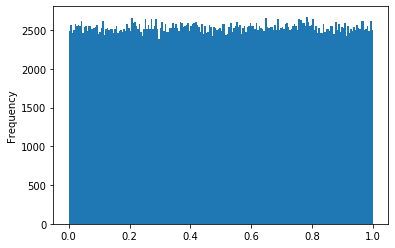

In [110]:
df_random['isFraud'].plot(kind='hist', bins=200)

In [46]:
df_random.to_csv('data/random_out.csv', header=True, index=False)

In [111]:
df_identity = pd.read_csv("data/train_identity.csv", header="infer")

In [112]:
df_transaction = pd.read_csv("data/train_transaction.csv", header="infer")

In [113]:
print(df_identity.shape)
print(df_transaction.shape)

(144233, 41)
(590540, 394)


In [114]:
df_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [204]:
df_transaction.head(20)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,0,68.500,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,117.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,117.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,1,29.000,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0

In [116]:
df_transaction['TransactionDT'] = df_transaction['TransactionDT'] - 86400

In [117]:
df_transaction['isFraud'].value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

In [118]:
df_transaction['TransactionID'].nunique()

590540

In [119]:
def check_missing(df):
    df_missing = pd.concat([df.nunique(), df.isnull().any(), df.isnull().sum()], axis=1)
    df_missing.columns = ['nunique', 'isnull_any', 'isnull_count']
    df_missing['missing'] = df_missing['isnull_count'] / float(len(df))
    return (df_missing)

In [120]:
df0 = df_transaction[ df_transaction['isFraud'] == 0 ]
df0_missing = check_missing(df0)

df1 = df_transaction[ df_transaction['isFraud'] == 1 ]
df1_missing = check_missing(df1)

In [121]:
df_missing = pd.merge(df0_missing, df1_missing, how="left", left_index=True, right_index=True)

In [122]:
df_missing

,nunique_x,isnull_any_x,isnull_count_x,missing_x,nunique_y,isnull_any_y,isnull_count_y,missing_y
TransactionID,569877,False,0,0.000000,20663,False,0,0.000000
isFraud,1,False,0,0.000000,1,False,0,0.000000
TransactionDT,553717,False,0,0.000000,20638,False,0,0.000000
TransactionAmt,20560,False,0,0.000000,2515,False,0,0.000000
ProductCD,5,False,0,0.000000,5,False,0,0.000000
card1,13350,False,0,0.000000,1740,False,0,0.000000
card2,500,True,8510,0.014933,327,True,423,0.020471
card3,106,True,1526,0.002678,62,True,39,0.001887
card4,4,True,1536,0.002695,4,True,41,0.001984
card5,118,True,4049,0.007105,49,True,210,0.010163


In [123]:
column = 'M1'
column = 'V141'

print(df_transaction[df_transaction['isFraud'] == 0][column].value_counts())
print(df_transaction[df_transaction['isFraud'] == 1][column].value_counts())

0.0    75921
1.0     2144
2.0      200
3.0       26
5.0        2
4.0        2
Name: V141, dtype: int64
0.0    3290
1.0     282
2.0      67
3.0      11
Name: V141, dtype: int64


In [124]:
df_transaction.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,238269.000000,37627.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,589271.000000,309743.000000,327662.000000,421618.000000,280699.000000,73187.000000,38917.000000,74926.000000,74926.000000,514518.000000,311253.000000,64717.000000,61952.000000,62187.000000,501427.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,421571.000000,421571.000000,421571.000000,421571.00000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,590226.000000,590226.00000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.00

In [125]:
df = df_transaction[['TransactionID', 'TransactionDT', 'V141']]

In [130]:
df.head()

,TransactionID,TransactionDT,V141,dt2,diff
0,2987000,0,NaN,1,1
1,2987001,1,NaN,69,68
2,2987002,69,NaN,99,30
3,2987003,99,NaN,106,7
4,2987004,106,0.0,110,4


In [129]:
df.tail()

,TransactionID,TransactionDT,V141,dt2,diff
590535,3577535,15724647,NaN,15724649,2
590536,3577536,15724649,NaN,15724679,30
590537,3577537,15724679,NaN,15724688,9
590538,3577538,15724688,NaN,15724731,43
590539,3577539,15724731,NaN,0,-15724731


In [128]:
df['dt2'] = 0
df.loc[0:(len(df)-2), 'dt2'] = df['TransactionDT'][1:].values
df['diff'] = df['dt2'] - df['TransactionDT']
df[ df['diff'] < 0]

,TransactionID,TransactionDT,V141,dt2,diff
590539,3577539,15724731,NaN,0,-15724731


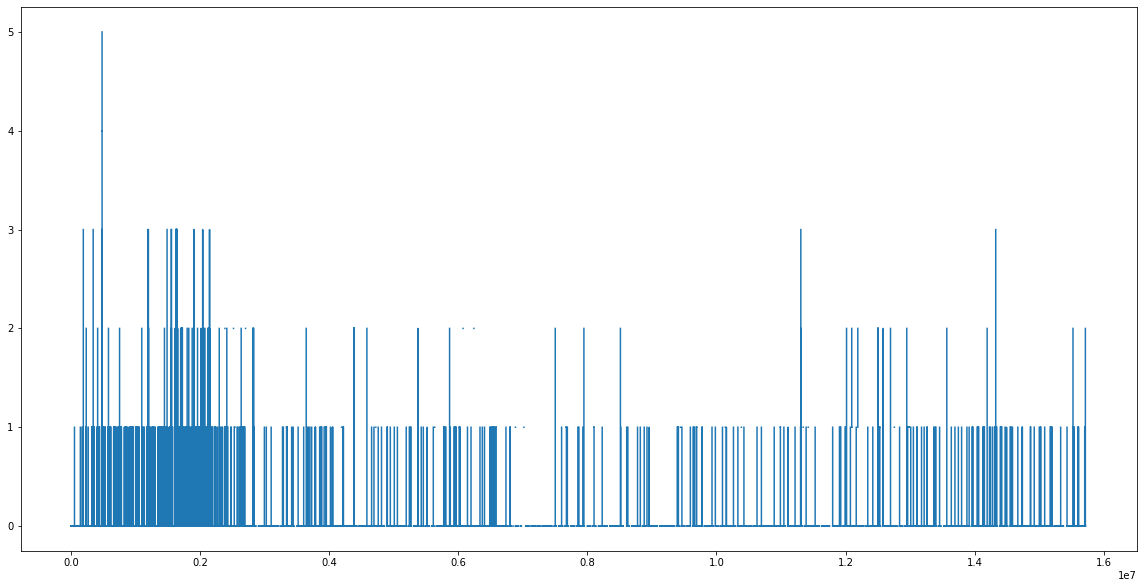

In [131]:
fig = plt.figure(figsize=(20, 10))
ax = plt.axes()
ax.plot(df['TransactionDT'], df['V141'], linestyle='-')
plt.show()

In [133]:
column = 'V141'
s0 = df_transaction[ df_transaction['isFraud'] == 0 ][column]
s1 = df_transaction[ df_transaction['isFraud'] == 1 ][column]

print(ks_2samp(s0, s1))

Ks_2sampResult(statistic=0.03926196610525068, pvalue=4.00619209743477e-27)


In [134]:
s0.value_counts()

0.0    75921
1.0     2144
2.0      200
3.0       26
5.0        2
4.0        2
Name: V141, dtype: int64

In [135]:
s0.isnull().sum()

491582

In [136]:
a0 = s0[ ~s0.isna() ]
a1 = s1[ ~s1.isna() ]

print(ks_2samp(a0, a1))

Ks_2sampResult(statistic=0.06830891596324762, pvalue=1.46809891623235e-14)


In [150]:
#-------------------------------------------------------------------------------
# Computes the statistical distance between two samples using the KS-test.
# This is used to determine if the distribution of the attribute columns are
# statistically different when failure = 0 and failure = 1.
#-------------------------------------------------------------------------------

#from scipy.stats.mstats import ks_2samp as ks_2sampm

def compute_statistical_distance(df, attribute):
    s0 = df[ df['isFraud'] == 0 ][attribute]
    s1 = df[ df['isFraud'] == 1 ][attribute]
    
    a0 = s0[ ~s0.isna() ]
    a1 = s1[ ~s1.isna() ]
    compare = ks_2samp(a0, a1)
    
    return ([attribute, compare.statistic, compare.pvalue])

In [139]:
all_columns = df_transaction.columns.tolist()

In [205]:
cat_columns = [
                'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 
                'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 
                'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9' 
              ]

excl_columns = cat_columns + ['TransactionID', 'isFraud', 'TransactionDT']

In [206]:
len(excl_columns)

23

In [207]:
compare_lists = Parallel(n_jobs=20)(
                    delayed(compute_statistical_distance)(df_transaction, col) 
                    for col in all_columns if col not in excl_columns
                )

In [208]:
df_compare = pd.DataFrame.from_records(compare_lists, columns=['feature', 'statistic', 'pvalue'])

In [209]:
df_compare.to_pickle('./data/pickles/df_kstest_comparison.pkl')
#dff = pd.read_pickle('./data/pickles/df_kstest_comparison.pkl')

In [210]:
df_compare

,feature,statistic,pvalue
0,TransactionAmt,0.075649,1.533201e-99
1,dist1,0.109743,3.564254e-49
2,dist2,0.073436,3.607917e-16
3,C1,0.187575,0.000000e+00
4,C2,0.204344,0.000000e+00
5,C3,0.004012,9.053311e-01
6,C4,0.330962,0.000000e+00
7,C5,0.287236,0.000000e+00
8,C6,0.132835,4.940649e-306
9,C7,0.278473,0.000000e+00


In [211]:
numeric_columns = sorted(df_compare[ df_compare['pvalue'] <= 0.01 ].sort_values(by='pvalue', ascending=False)['feature'].tolist())
len(numeric_columns)

336

In [212]:
df_numeric = df_transaction[numeric_columns].copy()

In [227]:
df_numeric.head()

,C1,C10,C11,C12,C13,C14,C2,C4,C5,C6,C7,C8,C9,D1,D10,D11,D12,D13,D14,D15,D2,D3,D4,D5,D6,D7,D8,D9,TransactionAmt,V10,V100,V101,V102,V103,V104,V105,V106,V108,V109,V11,V110,V111,V112,V113,V114,V115,V116,V12,V123,V124,V125,V126,V127,V128,V129,V13,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V15,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V16,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V17,V170,V171,V174,V175,V176,V177,V178,V179,V18,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V19,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V2,V20,V200,V201,V202,V203,V204,V208,V209,V21,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V22,V220,V221,V222,V224,V225,V226,V227,V228,V229,V23,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V24,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V26,V260,V261,V262,V263,V264,V265,V267,V268,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V287,V288,V289,V29,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V3,V30,V300,V301,V302,V303,V304,V306,V307,V308,V309,V31,V310,V312,V313,V314,V315,V316,V317,V318,V319,V32,V320,V321,V322,V323,V324,V326,V327,V328,V329,V33,V330,V331,V332,V333,V335,V336,V337,V338,V339,V34,V35,V36,V37,V38,V39,V4,V40,V42,V43,V44,V45,V46,V47,V48,V49,V5,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V66,V67,V69,V7,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V9,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,dist1,dist2
0,1.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,14.0,13.000000,13.000000,54.037533,17.901295,57.724444,0.000000,169.563231,13.000000,140.002441,42.335965,69.805717,41.63895,146.058108,0.561057,68.5,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,0.0,117.0,0.0,0.0,1.000000,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.036439,1.073915,1.125267,0.037696,0.048581,8.397006,3.708484,22.112946,0.156276,0.168601,0.765001,0.775313,0.000000,277.598028,6.46019,9.43271,0.7532,0.757423,0.767381,0.777485,0.817573,0.833461,2719.299775,0.00000,47453.181173,4.843938,6.594661,5.505955,877.888928,2239.912219,359.469437,3.929514,5.859501,0.168053,0.00000,1.436779,1.690908,0.127794,0.212639,1.376979,3.529245,6.649283,4.869012,0.000000,0.924123,0.253332,0.856243,0.484692,0.132364,0.173903,1.148799,1.843752,1.014755,1.038314,1.000000,1.213083,1.058984,1.237361,1.149845,0.945773,0.954227,1.08458,0.949385,0.961951,1.270749,1.000000,1.000000,1.119977,1.159106,444.147142,1078.327538,686.956931,8.888193,35.001872,0.000000,14.391835,385.137037,765.988339,536.302802,38.437547,133.208217,71.107143,1.054619,1.725784,1.367132,0.000000,0.169472,1.274912,1.359005,0.394748,0.191758,0.247612,0.147975,1.351928,1.63871,1.000000,1.465476,0.765506,1.005597,0.908388,2.092847,0.184106,0.307667,0.2535,0.127956,0.136965,1.000000,1.113463,1.178387,1.118562,0.876619,1.183723,1.025355,1.069493,1.042851,0.788588,0.794231,1.032048,1.162164,1.075113,0.806656,0.81495,1.250993,1.34351,0.967832,1.00000,0.964425,1.107161,1.013279,117.390676,201.657617,153.520534,36.525103,18.813407,7.712764,9.445133,8.464571,73.825549,107.151636,88.899939,31.797277,51.956645,42.328228,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00000,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.000000,0.0,0.0,6.220289,13.103775,9.184612,0.85104,0.296633,0.33679,1.312844,0.000000,0.775874,721.741883,1375.783644,1014.622782,59.16455,28.530903,55.352422,151.160542,100.700882,0.000000,0.542594,0.579198,1.108065,1.1624,0.166076,1.000000,0.177145,0.156118,0.168942,1.083891,1.120779,1.022286,1.038515,0.383174,0.397724,1.000000,0.164746,0.170579,0.182695,1.000000,1.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.0000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0000

In [224]:
replace = np.mean(df_numeric)

In [228]:
def impute_missing_numeric(df, replace):
    for col in df.columns.tolist():
        df[col].fillna(replace[col], inplace=True)
        
def impute_missing_categorical(df):
    for col in df.columns.tolist():
        df[col].fillna('NA', inplace=True)

In [226]:
impute_missing_numeric(df_numeric, replace)

In [214]:
df_categorical = df_transaction[cat_columns].copy()

In [230]:
df_categorical.head()

,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,W,13926,NA,150,discover,142,credit,315,87,NA,NA,T,T,T,M2,F,T,NA,NA,NA
1,W,2755,404,150,mastercard,102,credit,325,87,gmail.com,NA,NA,NA,NA,M0,T,T,NA,NA,NA
2,W,4663,490,150,visa,166,debit,330,87,outlook.com,NA,T,T,T,M0,F,F,F,F,F
3,W,18132,567,150,mastercard,117,debit,476,87,yahoo.com,NA,NA,NA,NA,M0,T,F,NA,NA,NA
4,H,4497,514,150,mastercard,102,credit,420,87,gmail.com,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [229]:
impute_missing_categorical(df_categorical)

In [232]:
df_categorical.shape

(590540, 20)

In [233]:
df_sub = df_transaction[['TransactionID', 'isFraud']]

In [236]:
df_sub = pd.merge(df_sub, df_categorical, how='left', left_index=True, right_index=True)
df_sub = pd.merge(df_sub, df_numeric, how='left', left_index=True, right_index=True)

In [239]:
df_sub.head()

,TransactionID,isFraud,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,C1,C10,C11,C12,C13,C14,C2,C4,C5,C6,C7,C8,C9,D1,D10,D11,D12,D13,D14,D15,D2,D3,D4,D5,D6,D7,D8,D9,TransactionAmt,V10,V100,V101,V102,V103,V104,V105,V106,V108,V109,V11,V110,V111,V112,V113,V114,V115,V116,V12,V123,V124,V125,V126,V127,V128,V129,V13,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V15,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V16,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V17,V170,V171,V174,V175,V176,V177,V178,V179,V18,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V19,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V2,V20,V200,V201,V202,V203,V204,V208,V209,V21,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V22,V220,V221,V222,V224,V225,V226,V227,V228,V229,V23,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V24,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V26,V260,V261,V262,V263,V264,V265,V267,V268,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V287,V288,V289,V29,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V3,V30,V300,V301,V302,V303,V304,V306,V307,V308,V309,V31,V310,V312,V313,V314,V315,V316,V317,V318,V319,V32,V320,V321,V322,V323,V324,V326,V327,V328,V329,V33,V330,V331,V332,V333,V335,V336,V337,V338,V339,V34,V35,V36,V37,V38,V39,V4,V40,V42,V43,V44,V45,V46,V47,V48,V49,V5,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V66,V67,V69,V7,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V9,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,dist1,dist2
0,2987000,0,W,13926,NA,150,discover,142,credit,315,87,NA,NA,T,T,T,M2,F,T,NA,NA,NA,1.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,14.0,13.000000,13.000000,54.037533,17.901295,57.724444,0.000000,169.563231,13.000000,140.002441,42.335965,69.805717,41.63895,146.058108,0.561057,68.5,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,0.0,117.0,0.0,0.0,1.000000,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.036439,1.073915,1.125267,0.037696,0.048581,8.397006,3.708484,22.112946,0.156276,0.168601,0.765001,0.775313,0.000000,277.598028,6.46019,9.43271,0.7532,0.757423,0.767381,0.777485,0.817573,0.833461,2719.299775,0.00000,47453.181173,4.843938,6.594661,5.505955,877.888928,2239.912219,359.469437,3.929514,5.859501,0.168053,0.00000,1.436779,1.690908,0.127794,0.212639,1.376979,3.529245,6.649283,4.869012,0.000000,0.924123,0.253332,0.856243,0.484692,0.132364,0.173903,1.148799,1.843752,1.014755,1.038314,1.000000,1.213083,1.058984,1.237361,1.149845,0.945773,0.954227,1.08458,0.949385,0.961951,1.270749,1.000000,1.000000,1.119977,1.159106,444.147142,1078.327538,686.956931,8.888193,35.001872,0.000000,14.391835,385.137037,765.988339,536.302802,38.437547,133.208217,71.107143,1.054619,1.725784,1.367132,0.000000,0.169472,1.274912,1.359005,0.394748,0.191758,0.247612,0.147975,1.351928,1.63871,1.000000,1.465476,0.765506,1.005597,0.908388,2.092847,0.184106,0.307667,0.2535,0.127956,0.136965,1.000000,1.113463,1.178387,1.118562,0.876619,1.183723,1.025355,1.069493,1.042851,0.788588,0.794231,1.032048,1.162164,1.075113,0.806656,0.81495,1.250993,1.34351,0.967832,1.00000,0.964425,1.107161,1.013279,117.390676,201.657617,153.520534,36.525103,18.813407,7.712764,9.445133,8.464571,73.825549,107.151636,88.899939,31.797277,51.956645,42.328228,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00000,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.000000,0.0,0.0,6.220289,13.103775,9.184612,0.85104,0.296633,0.33679,1.312844,0.000000,0.775874,721.741883,1375.783644,1014.622782,59.16455,28.530903,55.352422,151.160542,100.700882,0.000000,0.542594,0.579198,1.108065,1.1624,0.166076,1.000000,0.177145,0.156118,0.168942,1.083891,1.120779,1.022286,1.038515,0.383174,0.397724,1.000000,0.164746,0.1

In [240]:
crossvalidation = StratifiedKFold(n_splits = 3)
scoring_metrics = {
                    'Accuracy': 'accuracy',
                    'Recall': 'recall',
                    'Precision': 'precision',
                    'F1': 'f1',
                    'AUC': 'roc_auc'
                  }